# Preamble

In [1]:
from sympy import init_session
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_styles import analytic
import numpy as npy
import scipy as sp
%matplotlib widget
import os, glob, pathlib
from loky import get_reusable_executor
import dill as pickle
from sympy.utilities.lambdify import lambdastr
init_session()

IPython console for SymPy 1.12 (Python 3.12.0-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.12/



In [2]:
EXPRS = {}

In [3]:
def term_simplify(expr):
    run = 0
    for arg in expr.args:
        run += arg.simplify()
    return(run)

def term_multiply(expr, mult):
    run = 0
    for term in expr.args:
        run += term*mult
    term_simplify(run)
    return(run)

In [34]:
# Positive constant
M, G, q, mu1, mu2, m1, m2, b1, b2, j, tm0, te0, b1_3_2, b2_3_2 = symbols(
    r"M G q mu_1 mu_2 m_1, m_2, beta_1 beta_2 j T_{m\,0} T_{e\,0} b_{3/2}^{(1)}(\alpha_0) b_{3/2}^{(2)}(\alpha_0)",
    positive=True,
)
# Precession frequencies
om1, om2 = symbols("omega_1 omega_2")
# Angles of time
l1, l2, pom1, pom2, th1, th2 = symbols("l_1 l_2 varpi_1 varpi_2 theta_1 theta_2")
# Positive functions of time
e1, e2, a1, a2, n1, n2, alpha = symbols("e_1 e_2 a_1 a_2 n_1 n_2 alpha", positive=True)
# Actions
Gam1, Gam2, Lam1, Lam2 = symbols("Gamma_1 Gamma_2 Lambda_1 Lambda_2", positive=True)
# Derivatives
dth1, dth2 = symbols(r"\dot\theta_1 \dot\theta_2")

In [35]:
EXPRS[th1] = (j + 1) * l2 - j * l1 - pom1
EXPRS[th2] = (j + 1) * l2 - j * l1 - pom2
EXPRS[Lam1] = q*sqrt(a1)
EXPRS[Lam2] = sqrt(a1)
EXPRS[Gam1] = Rational(1,2)*q*sqrt(a1)*e1**2
EXPRS[Gam2] = Rational(1,2)*sqrt(a2)*e2**2

- Assume $a_2\approx a_{2,0}[=1]$ in denominator of perturbation term.
- $\beta_1=-f_{27}(\alpha_0)$ and $\beta_2=f_{31}(\alpha_0)$ 

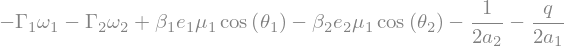

In [36]:
H_expr = -Rational(1,2)*q/a1 - Rational(1,2)*1/a2 + mu1*b1*e1*cos(th1) - mu1*b2*e2*cos(th2) - Gam1*om1 - Gam2*om2 
H_expr

In [37]:
def diff(expr, var):
    run = expr.diff(var)
    for key in EXPRS.keys():
        run += expr.diff(key)*EXPRS[key].diff(var)
    return(run)

Doing 2 different R_i for each planet to reduce typos over from Murray & Dermott.

Units are in $[n_{2,0}]$, $[a_{2,0}]$, and $[M]$

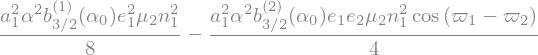

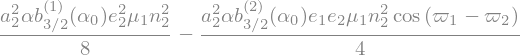

In [62]:
#A11 = Rational(1,4)*n1*m2/(M+m1)*alpha*alpha*b1_3_2
#A12 = -Rational(1,4)*n1*m2/(M+m1)*alpha*alpha*b2_3_2
#A21 = -Rational(1,4)*n2*m1/(M+m2)*alpha*b2_3_2
#A22 = Rational(1,4)*n2*m1/(M+m2)*alpha*b1_3_2
A11 = Rational(1,4)*n1*mu2*alpha*alpha*b1_3_2
A12 = -Rational(1,4)*n1*mu2*alpha*alpha*b2_3_2
A21 = -Rational(1,4)*n2*mu1*alpha*b2_3_2
A22 = Rational(1,4)*n2*mu1*alpha*b1_3_2

R1 = (n1*a1**2*(Rational(1,2)*A11*e1**2 + A12*e1*e2*cos(pom1-pom2))).expand()
R2 = (n2*a2**2*(Rational(1,2)*A22*e2**2 + A21*e1*e2*cos(pom1-pom2))).expand()
#term_multiply(R1.expand().subs(n1**2,G*M*m1/a1**3),1/(G*M*m2)).subs({m1:mu1*M,m2:mu2*M}).cancel()
display(R1)
display(R2)

# Equations of motion

## Resonant

In [ ]:

#edot = Gamdot/(Lam*e) - term_multiply(Lamdot, Rational(1,2)/Lam*e)

## Secular

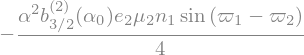

In [65]:
e1_dot_sec = -R1.diff(pom1)/(n1*a1**2*e1)
e1_dot_sec

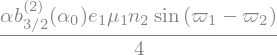

In [66]:
e2_dot_sec = -R2.diff(pom2)/(n2*a2**2*e2)
e2_dot_sec

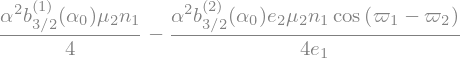

In [68]:
pom1_dot_sec = term_multiply(R1.diff(e1),1/(n1*a1**2*e1))
pom1_dot_sec

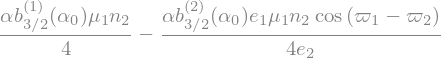

In [69]:
pom2_dot_sec = term_multiply(R2.diff(e2),1/(n2*a2**2*e2))
pom2_dot_sec